In [1]:
import os
import torch
from diffusers import DDIMScheduler,DiffusionPipeline
import torch.nn.functional as F
import cv2
from torchvision.utils import save_image
from diffusers.utils import load_image
from torchvision.transforms.functional import to_tensor, gaussian_blur
from matplotlib import pyplot as plt
torch.cuda.set_device(0)  # set the GPU device

/usr/local/miniconda3/envs/AE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Switch to "AttentiveEraser" dictionary
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)

In [3]:
dtype = torch.float16
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)

#model_path = "stabilityai/stable-diffusion-xl-base-1.0"
model_path = "/hy-tmp/stable-diffusion-xl-base-1.0" # change this to the path of the model if you are loading the model offline

pipeline = DiffusionPipeline.from_pretrained(
    model_path,
    custom_pipeline="./pipelines/pipeline_stable_diffusion_xl_attentive_eraser.py",
    scheduler=scheduler,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=dtype,
).to(device)
pipeline.enable_attention_slicing()
pipeline.enable_model_cpu_offload()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]


In [4]:
""" #freeu can further improve results in some cases(https://github.com/ChenyangSi/FreeU)
from utils import register_free_upblock2d, register_free_crossattn_upblock2d
register_free_upblock2d(pipeline, b1=1.3, b2=1.4, s1=0.9, s2=0.2)
register_free_crossattn_upblock2d(pipeline, b1=1.3, b2=1.4, s1=0.9, s2=0.2) """

' #freeu can further improve results in some cases(https://github.com/ChenyangSi/FreeU)\nfrom utils import register_free_upblock2d, register_free_crossattn_upblock2d\nregister_free_upblock2d(pipeline, b1=1.3, b2=1.4, s1=0.9, s2=0.2)\nregister_free_crossattn_upblock2d(pipeline, b1=1.3, b2=1.4, s1=0.9, s2=0.2) '

In [5]:
seed=123 
g = torch.Generator('cuda').manual_seed(seed)
def preprocess_image(image_path, device):
    image = to_tensor((load_image(image_path)))
    image = image.unsqueeze_(0).float() * 2 - 1 # [0,1] --> [-1,1]
    if image.shape[1] != 3:
        image = image.expand(-1, 3, -1, -1)
    image = F.interpolate(image, (1024, 1024))
    image = image.to(dtype).to(device)
    return image

def preprocess_mask(mask_path, device):
    mask = to_tensor((load_image(mask_path, convert_method=lambda img: img.convert('L'))))
    mask = mask.unsqueeze_(0).float()  # 0 or 1
    mask = F.interpolate(mask, (1024, 1024))
    mask = gaussian_blur(mask, kernel_size=(77, 77))
    mask[mask < 0.1] = 0
    mask[mask >= 0.1] = 1
    mask = mask.to(dtype).to(device)
    return mask


sample = "an1024"
prompt = "" # Set prompt to null
out_dir = f"./workdir_xl/{sample}/"
os.makedirs(out_dir, exist_ok=True)
sample_count = len(os.listdir(out_dir))
out_dir = os.path.join(out_dir, f"sample_{sample_count}")
os.makedirs(out_dir, exist_ok=True)
SOURCE_IMAGE_PATH = f"./examples/img/{sample}.png"
MASK_PATH = f"./examples/mask/{sample}_mask.png"


source_image = preprocess_image(SOURCE_IMAGE_PATH, device)
mask = preprocess_mask(MASK_PATH, device)

In [6]:
strength = 0.8 # inpainting strength
num_inference_steps = 50 # number of inference steps
START_STEP = 0 # AAS start step
END_STEP = int(strength*num_inference_steps) # AAS end step
LAYER = 34 # 0~23down,24~33mid,34~69up /AAS start layer 
END_LAYER = 70 # AAS end layer
ss_steps = 9 # similarity suppression steps
ss_scale = 0.3 # similarity suppression scale
rm_guidance_scale = 9 # removal guidance scale

In [7]:
image = pipeline(
    prompt=prompt,
    image=source_image,
    mask_image=mask,
    height=1024,
    width=1024,
    AAS=True, # enable AAS
    strength=strength, # inpainting strength
    rm_guidance_scale=rm_guidance_scale, # removal guidance scale
    ss_steps = ss_steps, # similarity suppression steps
    ss_scale = ss_scale, # similarity suppression scale
    AAS_start_step=START_STEP, # AAS start step
    AAS_start_layer=LAYER, # AAS start layer 
    AAS_end_layer=END_LAYER, # AAS end layer
    num_inference_steps=num_inference_steps, # number of inference steps # AAS_end_step = int(strength*num_inference_steps)
    generator=g,
    guidance_scale=1,
    output_type='pt'
).images[0]


/usr/local/miniconda3/envs/AE/lib/python3.9/site-packages/diffusers/image_processor.py:724: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(


AAS at denoising steps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
AAS at U-Net layers:  [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
start AAS


100%|██████████| 40/40 [00:19<00:00,  2.08it/s]


In [8]:
def make_redder(img, mask, increase_factor=0.4):
    img_redder = img.clone()
    mask_expanded = mask.expand_as(img)
    img_redder[0][mask_expanded[0] == 1] = torch.clamp(img_redder[0][mask_expanded[0] == 1] + increase_factor, 0, 1)
    
    return img_redder
img = (source_image* 0.5 + 0.5).squeeze(0)
mask_red = mask.squeeze(0)
img_redder = make_redder(img, mask_red)

In [9]:
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import ImageFilter
pil_mask = to_pil_image(mask.squeeze(0))
pil_mask_blurred = pil_mask.filter(ImageFilter.GaussianBlur(radius=15))
mask_blurred = to_tensor(pil_mask_blurred).unsqueeze_(0).to(mask.device)
msak_f = 1-(1-mask)*(1-mask_blurred)

Syntheiszed images are saved in ./workdir_xl/an1024/sample_3


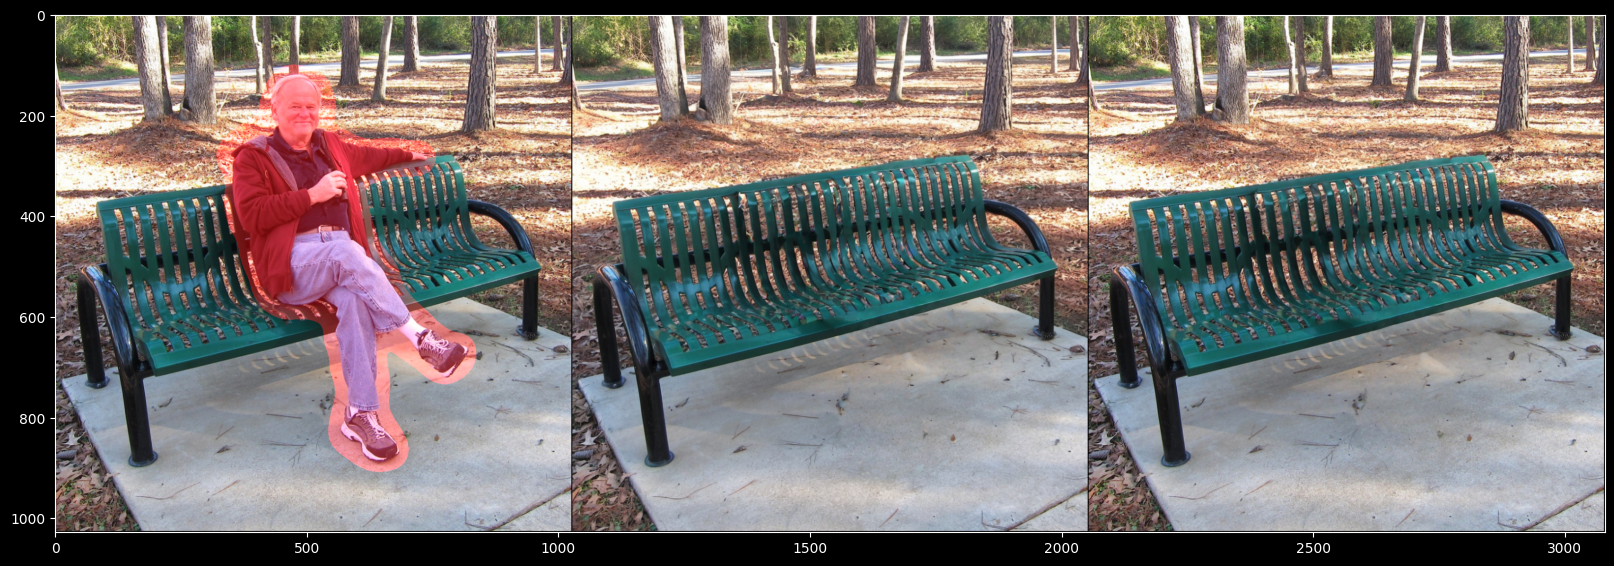

In [10]:
image_1=image.unsqueeze(0)
out_tile = msak_f * image_1 + (1 - msak_f) * (source_image* 0.5 + 0.5)
out_image = torch.concat([img_redder.unsqueeze(0),
                         image_1,
                         out_tile],
                         dim=0)
save_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[1], os.path.join(out_dir, f"AE_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[2], os.path.join(out_dir, f"AE_tile_step{END_STEP}_layer{LAYER}.png"))
print("Syntheiszed images are saved in", out_dir)
img_ori = cv2.imread(os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 26))
plt.imshow(img_ori)